In [2]:
import kagglehub
import csv
import re

# Download latest version
folder_path = kagglehub.dataset_download("karkavelrajaj/amazon-sales-dataset")
print(folder_path)
file_path = folder_path + "/amazon.csv"

fields = []
text_rows = []

df = pd.read_csv(file_path)

with open(file_path, "r", encoding="utf-8") as csvfile:
    csvreader = csv.reader(csvfile)

    fields = next(csvreader)
    for text_row in csvreader:
        text_rows.append(text_row)

print(fields)
print(text_rows[0])
print(text_rows[1])
print(text_rows[2])

C:\Users\Benso\.cache\kagglehub\datasets\karkavelrajaj\amazon-sales-dataset\versions\1
['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']
['B07JW9H4J1', 'Wayona Nylon Braided USB to Lightning Fast Charging and Data Sync Cable Compatible for iPhone 13, 12,11, X, 8, 7, 6, 5, iPad Air, Pro, Mini (3 FT Pack of 1, Grey)', 'Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables', '₹399', '₹1,099', '64%', '4.2', '24,269', "High Compatibility : Compatible With iPhone 12, 11, X/XsMax/Xr ,iPhone 8/8 Plus,iPhone 7/7 Plus,iPhone 6s/6s Plus,iPhone 6/6 Plus,iPhone 5/5s/5c/se,iPad Pro,iPad Air 1/2,iPad mini 1/2/3,iPod nano7,iPod touch and more apple devices.|Fast Charge&Data Sync : It can charge and sync simultaneously at a rapid speed, Compatible with any charging adaptor, multi-port

Dataset downloaded to: C:\Users\Benso\.cache\kagglehub\datasets\karkavelrajaj\amazon-sales-dataset\versions\1
Raw dataset shape: (1465, 16)
Cleaned dataset shape: (1462, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1462 non-null   object 
 1   product_name         1462 non-null   object 
 2   category             1462 non-null   object 
 3   discounted_price     1462 non-null   float64
 4   actual_price         1462 non-null   float64
 5   discount_percentage  1462 non-null   float64
 6   rating               1462 non-null   float64
 7   rating_count         1462 non-null   float64
 8   about_product        1462 non-null   object 
 9   user_id              1462 non-null   object 
 10  user_name            1462 non-null   object 
 11  review_id            1462 non-null   object 
 12  review_title       

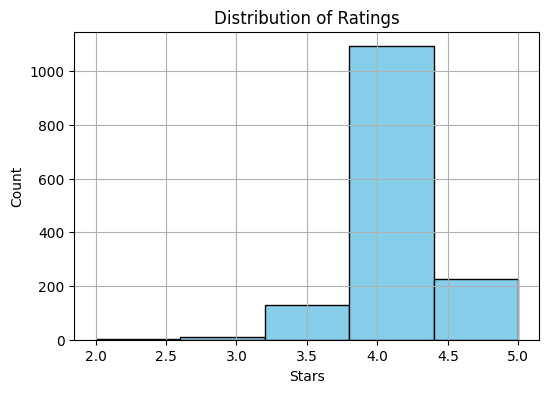

Average rating: 4.1

Top 5 Categories:
 category
Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables    231
Electronics|WearableTechnology|SmartWatches                                           76
Electronics|Mobiles&Accessories|Smartphones&BasicMobiles|Smartphones                  68
Electronics|HomeTheater,TV&Video|Televisions|SmartTelevisions                         63
Electronics|Headphones,Earbuds&Accessories|Headphones|In-Ear                          52
Name: count, dtype: int64


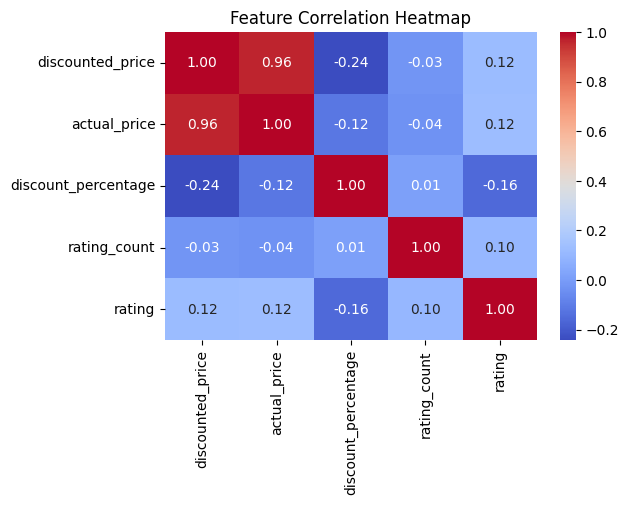

R² (numeric features): 0.0582
RMSE (numeric features): 0.278


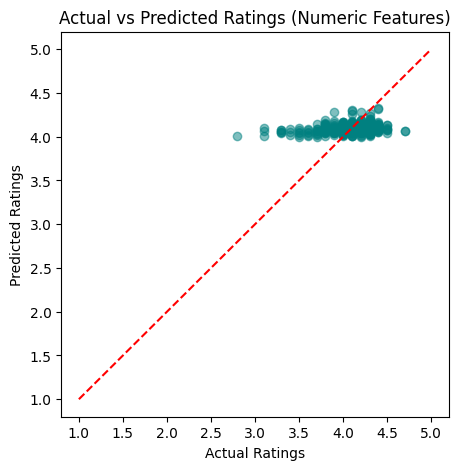


R² (text reviews): 0.0794
RMSE (text reviews): 0.274

=== Linear Regression Summary ===
R² (numeric only): 0.0582
R² (text reviews): 0.0794
RMSE (numeric): 0.278
RMSE (text): 0.274

Takeaways:
- Price, discount, and review count barely explain rating variance (~6%)
- Adding text (TF-IDF) helps a bit (~8%) but still weak overall
- Linear regression clearly isn't enough for sentiment-driven data


In [5]:
# ====================================================
# CS 4342 Final Project - Amazon Ratings (Linear Model)
# ====================================================

# --- Imports ---
import pandas as pd
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

# ----------------------------------------------------
# 1. Get the dataset
# ----------------------------------------------------
folder_path = kagglehub.dataset_download("karkavelrajaj/amazon-sales-dataset")
print("Dataset downloaded to:", folder_path)

# find CSV file in that folder
file_name = [f for f in os.listdir(folder_path) if f.endswith(".csv")][0]
file_path = os.path.join(folder_path, file_name)

df = pd.read_csv(file_path)
print("Raw dataset shape:", df.shape)
df.head()

# ----------------------------------------------------
# 2. Clean up the data
# ----------------------------------------------------
# get rid of ₹ signs and commas, convert rupees -> USD
df['discounted_price'] = df['discounted_price'].replace('[₹,]', '', regex=True).astype(float) * 0.011
df['actual_price'] = df['actual_price'].replace('[₹,]', '', regex=True).astype(float) * 0.011

# remove '%' from discount and turn into float
df['discount_percentage'] = df['discount_percentage'].str.rstrip('%').astype(float)

# rating + rating_count to numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating_count'] = df['rating_count'].replace(',', '', regex=True).astype(float)

# drop rows missing these key values
df = df.dropna(subset=['discounted_price','actual_price','discount_percentage','rating_count','rating'])
print("Cleaned dataset shape:", df.shape)
df.info()

# ----------------------------------------------------
# 3. Quick EDA
# ----------------------------------------------------
plt.figure(figsize=(6,4))
df['rating'].hist(bins=5, color='skyblue', edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.show()

print("Average rating:", round(df['rating'].mean(),2))
print("\nTop 5 Categories:\n", df['category'].value_counts().head())

# correlation heatmap for numeric features
plt.figure(figsize=(6,4))
sns.heatmap(df[['discounted_price','actual_price','discount_percentage','rating_count','rating']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# ----------------------------------------------------
# 4. Linear Regression (numeric features)
# ----------------------------------------------------
X = df[['discounted_price', 'actual_price', 'discount_percentage', 'rating_count']]
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_num = LinearRegression()
reg_num.fit(X_train, y_train)

r2_num = reg_num.score(X_test, y_test)
y_pred = reg_num.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² (numeric features):", round(r2_num,4))
print("RMSE (numeric features):", round(rmse,3))

# scatter plot actual vs predicted
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings (Numeric Features)")
plt.plot([1,5],[1,5],'r--')
plt.show()

# ----------------------------------------------------
# 5. Linear Regression (review text using TF-IDF)
# ----------------------------------------------------
X_text = df['review_content'].fillna("")
y_text = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X_text, y_text, test_size=0.2, random_state=42)

reg_text = make_pipeline(TfidfVectorizer(max_features=5000), LinearRegression())
reg_text.fit(X_train, y_train)

r2_text = reg_text.score(X_test, y_test)
y_pred_text = reg_text.predict(X_test)
rmse_text = np.sqrt(mean_squared_error(y_test, y_pred_text))

print("\nR² (text reviews):", round(r2_text,4))
print("RMSE (text reviews):", round(rmse_text,3))

# ----------------------------------------------------
# 6. Wrap-up
# ----------------------------------------------------
print("\n=== Linear Regression Summary ===")
print(f"R² (numeric only): {r2_num:.4f}")
print(f"R² (text reviews): {r2_text:.4f}")
print(f"RMSE (numeric): {rmse:.3f}")
print(f"RMSE (text): {rmse_text:.3f}")

print("\nTakeaways:")
print("- Price, discount, and review count barely explain rating variance (~6%)")
print("- Adding text (TF-IDF) helps a bit (~8%) but still weak overall")
print("- Linear regression clearly isn't enough for sentiment-driven data")
